In this notebook, K-NN is used to classify grayscale images of cats, dogs, and pandas. The goal is to compare Manhattan (L1) and Euclidean (L2) distances using 5-fold cross-validation and different values of K.

In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt


## Dataset and Preprocessing

The dataset contains three classes (cat, dog, panda) stored in separate folders inside `animal_dataset`. All images are converted to grayscale and resized to 32×32 pixels, then flattened into feature vectors for k-NN. This reduces dimensionality and computation while preserving key visual information.

In [2]:
data_dir = "animal_dataset"

classes = sorted(os.listdir(data_dir))
print("Classes:", classes)

X = []
y = []

img_size = 32

for label, cls in enumerate(classes):
    cls_folder = os.path.join(data_dir, cls)
    for fname in os.listdir(cls_folder):
        fpath = os.path.join(cls_folder, fname)
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size))
        X.append(img.flatten())
        y.append(label)

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int64)

print("X shape:", X.shape)
print("y shape:", y.shape)


Classes: ['cat', 'dog', 'panda']
X shape: (300, 1024)
y shape: (300,)


## Model Building and Evaluation

A k-nearest neighbors classifier is trained using two distance metrics: Manhattan (L1) and Euclidean (L2). To evaluate performance robustly, 5-fold cross-validation is applied on the training set for several values of K, and accuracy is computed on each validation fold.


In [3]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

k_values = [1, 3, 5, 7, 9, 11]
metrics = ["manhattan", "euclidean"]

results = {m: [] for m in metrics}
all_k_fold_acc = {m: {k: [] for k in k_values} for m in metrics}

for metric in metrics:
    print(f"\n=== Metric: {metric} ===")
    for k in k_values:
        fold_accuracies = []
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
            knn.fit(X_train, y_train)
            acc = knn.score(X_val, y_val)
            fold_accuracies.append(acc)

        mean_acc = np.mean(fold_accuracies)
        results[metric].append(mean_acc)
        all_k_fold_acc[metric][k] = fold_accuracies
        print(f"K = {k}, accuracies per fold = {fold_accuracies}, mean = {mean_acc:.4f}")



=== Metric: manhattan ===
K = 1, accuracies per fold = [0.4166666666666667, 0.31666666666666665, 0.48333333333333334, 0.2, 0.5333333333333333], mean = 0.3900
K = 3, accuracies per fold = [0.35, 0.48333333333333334, 0.4, 0.36666666666666664, 0.38333333333333336], mean = 0.3967
K = 5, accuracies per fold = [0.31666666666666665, 0.45, 0.4166666666666667, 0.3333333333333333, 0.35], mean = 0.3733
K = 7, accuracies per fold = [0.31666666666666665, 0.48333333333333334, 0.43333333333333335, 0.3333333333333333, 0.3333333333333333], mean = 0.3800
K = 9, accuracies per fold = [0.35, 0.5333333333333333, 0.43333333333333335, 0.3333333333333333, 0.4166666666666667], mean = 0.4133
K = 11, accuracies per fold = [0.4166666666666667, 0.4666666666666667, 0.45, 0.36666666666666664, 0.4], mean = 0.4200

=== Metric: euclidean ===
K = 1, accuracies per fold = [0.3, 0.3, 0.4666666666666667, 0.2, 0.48333333333333334], mean = 0.3500
K = 3, accuracies per fold = [0.3333333333333333, 0.4666666666666667, 0.4, 0.3

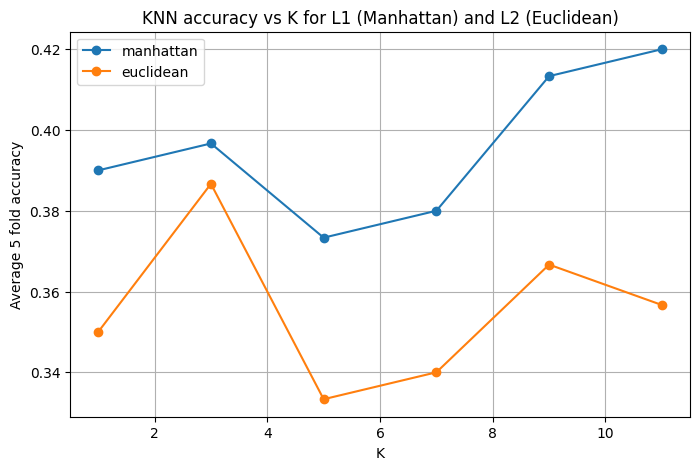

In [4]:
plt.figure(figsize=(8, 5))
for metric in metrics:
    plt.plot(k_values, results[metric], marker='o', label=metric)

plt.xlabel("K")
plt.ylabel("Average 5 fold accuracy")
plt.title("KNN accuracy vs K for L1 (Manhattan) and L2 (Euclidean)")
plt.legend()
plt.grid(True)
plt.show()


## Results and Analysis

For each distance metric and each value of K, the average accuracy across the 5 folds is computed. The accuracy versus K is plotted for both Manhattan (L1) and Euclidean (L2) to visualize how the choice of K and distance metric affects performance.


In [5]:
best_k = {}
for metric in metrics:
    idx_best = int(np.argmax(results[metric]))
    best_k[metric] = k_values[idx_best]
    print(f"Best K for {metric}: {best_k[metric]}, accuracy = {results[metric][idx_best]:.4f}")


Best K for manhattan: 11, accuracy = 0.4200
Best K for euclidean: 3, accuracy = 0.3867


The best K for each metric is selected based on the highest mean cross-validation accuracy, which is used to train a final model on the full dataset.

In [6]:
metric_best_overall = max(metrics, key=lambda m: max(results[m]))
k_best_overall = best_k[metric_best_overall]
print(f"Overall best metric: {metric_best_overall}, K = {k_best_overall}")

model = KNeighborsClassifier(n_neighbors=k_best_overall, metric=metric_best_overall)
model.fit(X, y)

Overall best metric: manhattan, K = 11


,n_neighbors,11
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'manhattan'
,metric_params,None
,n_jobs,None


In [7]:
train_acc = model.score(X, y)
print("Training accuracy of final model:", train_acc)

Training accuracy of final model: 0.5033333333333333


In [8]:
from sklearn.metrics import classification_report

y_pred = model.predict(X)
print(classification_report(y, y_pred, target_names=classes))


              precision    recall  f1-score   support

         cat       0.51      0.61      0.55       100
         dog       0.45      0.71      0.55       100
       panda       0.86      0.19      0.31       100

    accuracy                           0.50       300
   macro avg       0.61      0.50      0.47       300
weighted avg       0.61      0.50      0.47       300



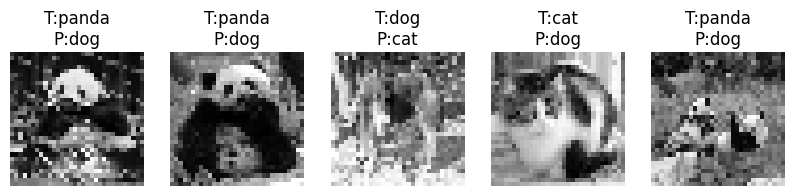

In [9]:
np.random.seed(42)
idxs = np.random.choice(len(X), size=5, replace=False)

plt.figure(figsize=(10, 3))

for j, i in enumerate(idxs):
    pred_label = model.predict(X[i].reshape(1, -1))[0]
    true_class = classes[y[i]]
    pred_class = classes[pred_label]

    img = X[i].reshape(img_size, img_size)

    plt.subplot(1, 5, j+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"T:{true_class}\nP:{pred_class}")
    plt.axis("off")

plt.show()